In [13]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

In [14]:
cudnn.benchmark = True
plt.ion()

In [15]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])  for x in ['train', 'val']
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, num_workers=4, shuffle=True) for x in ['train', 'val']
}
data_sizes = {
    x: len(image_datasets[x]) for x in ['train', 'val']
}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

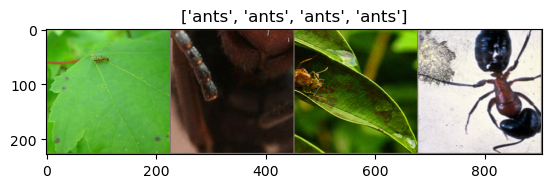

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001F5927A3CA8>
Traceback (most recent call last):
  File "F:\Anaconda\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "F:\Anaconda\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 1316, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [16]:
import numpy as np

def imshow(inp, title=None):
    # 可视化一组Tensor图片
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """ 训练模型，并返回在验证集上的最佳模型和准确率
    Args:
    - model(nn.Module): 要训练的模型
    - criterion: 损失函数
    - optimizer(optim.Optimizer): 优化器
    - scheduler: 学习率调度器
    - num_epochs(int): 最大 epoch 数
    Return:
    - model(nn.Module): 最佳模型
    - best_acc(float): 最佳准确率
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 训练集和验证集交替进行前向传播
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 设置为训练模式，可以更新网络参数
            else:
                model.eval()   # 设置为预估模式，不可更新网络参数

            running_loss = 0.0
            running_corrects = 0

            # 遍历数据集
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清空梯度，避免累加了上一次的梯度
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # 正向传播
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 反向传播且仅在训练阶段进行优化
                    if phase == 'train':
                        loss.backward() # 反向传播
                        optimizer.step()

                # 统计loss、准确率
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 发现了更优的模型，记录起来
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 加载训练的最好的模型
    model.load_state_dict(best_model_wts)
    return model

In [18]:
# 观察模型预测结果

def visualize_model(model, num_images=6):
    was_training = model.training # 记住之前的训练模式
    model.eval() # 进入评估模式
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {0}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(model=was_training)




In [19]:
# 微调模型
model = models.resnet18(pretrained=True) # 加载预训练模型
num_ftrs = model.fc.in_features # 获取低级特征维度
model.fc = nn.Linear(num_ftrs, 2) # 替换新的输出层
model = model.to(device)
# 交叉熵作为损失函数
criterion = nn.CrossEntropyLoss()
# 所有参数都参加训练
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# 每过 7 个 epoch 将学习率变为原来的 0.1

In [20]:
model_ft = train_model(model, criterion, optimizer_ft, scheduler, num_epochs=30) # 开始训练

Epoch 0/29
----------
train Loss: 0.4771 Acc: 0.7459
val Loss: 0.7179 Acc: 0.7712

Epoch 1/29
----------
train Loss: 0.6446 Acc: 0.7213
val Loss: 0.2072 Acc: 0.9412

Epoch 2/29
----------
train Loss: 0.4622 Acc: 0.8115
val Loss: 0.3047 Acc: 0.8824

Epoch 3/29
----------
train Loss: 0.5158 Acc: 0.8074
val Loss: 0.2220 Acc: 0.8889

Epoch 4/29
----------
train Loss: 0.3946 Acc: 0.8443
val Loss: 0.2926 Acc: 0.8758

Epoch 5/29
----------
train Loss: 0.4125 Acc: 0.8156
val Loss: 0.2498 Acc: 0.9020

Epoch 6/29
----------
train Loss: 0.5107 Acc: 0.8033
val Loss: 0.1997 Acc: 0.9150

Epoch 7/29
----------
train Loss: 0.3247 Acc: 0.8607
val Loss: 0.2853 Acc: 0.9085

Epoch 8/29
----------
train Loss: 0.4747 Acc: 0.8361
val Loss: 0.7796 Acc: 0.7451

Epoch 9/29
----------
train Loss: 0.3736 Acc: 0.8361
val Loss: 0.2920 Acc: 0.8758

Epoch 10/29
----------
train Loss: 0.3971 Acc: 0.8197
val Loss: 0.4020 Acc: 0.8758

Epoch 11/29
----------
train Loss: 0.4867 Acc: 0.8074
val Loss: 0.4207 Acc: 0.8431

Ep

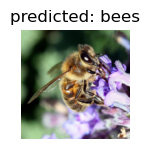

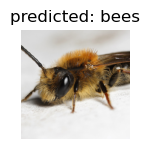

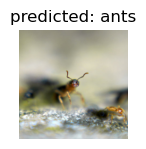

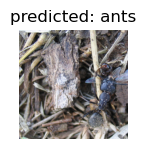

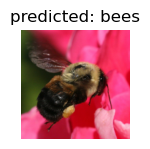

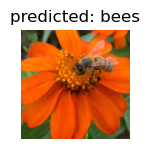

In [21]:
visualize_model(model_ft)

In [24]:
# 保存
SAVE_PATH = './model_path'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
sd = model.state_dict()
print('Save state dict device = %s' % (sd['conv1.weight'].device))
torch.save(model.state_dict(), SAVE_PATH)

Save state dict device = cuda:0


In [25]:
# 加载模型
sd = torch.load(SAVE_PATH)
print('Loaded state dict device = %s' % (sd['conv1.weight'].device))

Loaded state dict device = cuda:0
